In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [272]:
# %% Morp Registration
from importlib import reload
import os
import random
import pathlib
import re

import nibabel as nib
import cv2
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.morphology as morp
import skimage.measure as meas
from scipy.ndimage import rotate
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh
import pyqtgraph

import general.utils as u
import general.array_morphology as am
import ssm.icp as icp
import ssm.dijkstra as dij
import ssm.sample_mesh as smesh
import ssm.shape as sh

def reload_modules():
    for modl in [u, am, icp, dij, smesh, sh]:
        reload(modl)

reload_modules()

In [3]:
%matplotlib notebook

# 0) Sampling

In [403]:
reload_modules()
def create_grid_graph(W, H):
    graph = dij.Graph()

    for i in range(1, W - 1):
        for j in range(1, H - 1):
            if (i, j) in graph.nodes:
                continue
            graph.add_node((i, j))
            for (k1, k2) in [(-1, 0), (1, 0), (0, 1), (0, -1),]:
                graph.add_node((i + k1, j + k2))
                value = 1
                graph.add_edge((i, j), (i + k1, j + k2), value)
                graph.add_edge((i + k1, j + k2), (i, j), value)
            for (k1, k2) in [(1, 1), (1, -1), (-1, 1), (-1, -1)]:
                graph.add_node((i + k1, j + k2))
                value = np.sqrt(2)
                graph.add_edge((i, j), (i + k1, j + k2), value)
                graph.add_edge((i + k1, j + k2), (i, j), value)
                             
    return graph

In [404]:
n = 100
graph = create_grid_graph(n, n)

In [405]:
%%time
reload_modules()
visited, path = dij.dijsktra(graph, [(n//2, n//2)])

CPU times: user 3.09 s, sys: 0 ns, total: 3.09 s
Wall time: 3.08 s


<IPython.core.display.Javascript object>


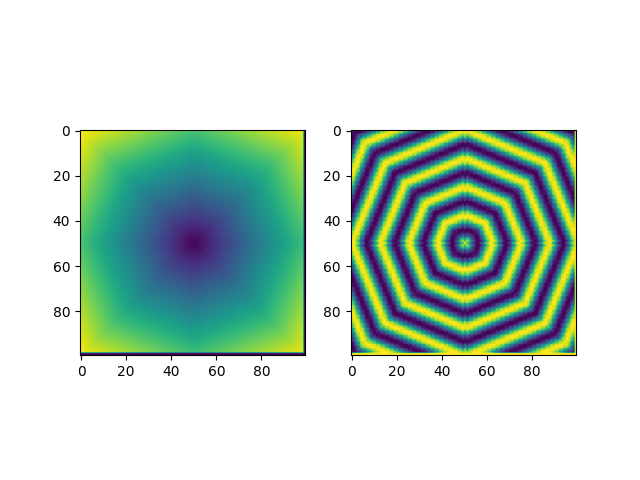

In [406]:
fig, axs = plt.subplots(1, 2)

points = []
ar = np.zeros((n, n))
for (i, j) in visited:
    ar[i, j] = visited[(i, j)]

axs[0].imshow(ar)
axs[1].imshow(np.cos(.5 * ar))


In [5]:
%%time
path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-11.nii.gz")
seg1n = nib.load(path_segm)
seg1 = np.round(seg1n.get_fdata()) == 2
reg1 = (u.get_most_important_regions(seg1) > 0).astype(int)
verts1, faces1, normals1, values1 = meas.marching_cubes(reg1, step_size=2)
print(len(verts1), len(faces1))

11328 22652
CPU times: user 8.67 s, sys: 824 ms, total: 9.49 s
Wall time: 9.49 s


<IPython.core.display.Javascript object>


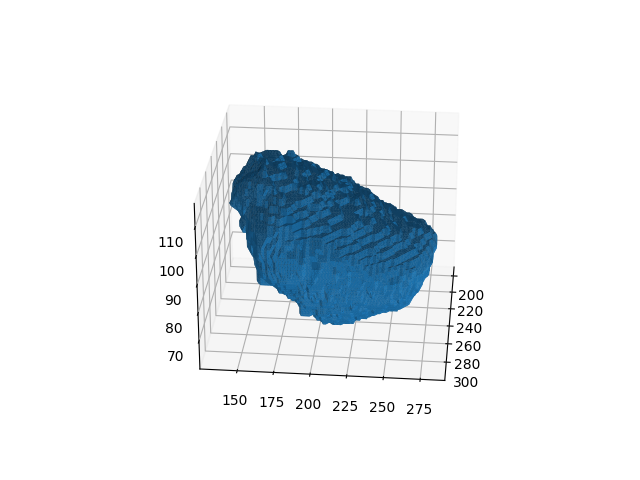

In [6]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(*verts1.T, triangles=faces1)


In [7]:
%%time
gmesh = dij.Graph()
for tri in faces1:
    for i in range(2):
        for j in range(i + 1, 3):
            gmesh.add_node(tri[i])
            gmesh.add_node(tri[j])
            value = np.linalg.norm(verts1[tri[i]] - verts1[tri[j]])
            gmesh.add_edge(tri[i], tri[j], value)
            gmesh.add_edge(tri[j], tri[i], value)
    

CPU times: user 608 ms, sys: 310 ms, total: 918 ms
Wall time: 605 ms


In [7]:
%%time
reload_modules()
visited, path = dij.dijsktra(gmesh, initial_set=[0])

CPU times: user 151 ms, sys: 1.46 ms, total: 153 ms
Wall time: 153 ms


In [8]:
ar_dist = np.zeros(len(visited))
for key, value in visited.items():
    ar_dist[key] = value

In [8]:
%%time
n_points = 40
cur_point = 0

all_points = [cur_point]
for _ in tqdm(range(1, n_points)):
    visited, path = dij.dijsktra(gmesh, initial_set=all_points)
    ar_dist = np.zeros(len(visited))
    for key, value in visited.items():
        ar_dist[key] = value
    cur_point = ar_dist.argmax()
    all_points.append(cur_point)

100%|██████████| 39/39 [02:24<00:00,  3.71s/it]

CPU times: user 2min 24s, sys: 0 ns, total: 2min 24s
Wall time: 2min 24s


In [13]:
colors = ar_dist[faces1]

In [16]:
np.stack((colors.mean(1), colors.mean(1), colors.mean(1)), axis=-1).shape

(5540, 3)

<IPython.core.display.Javascript object>


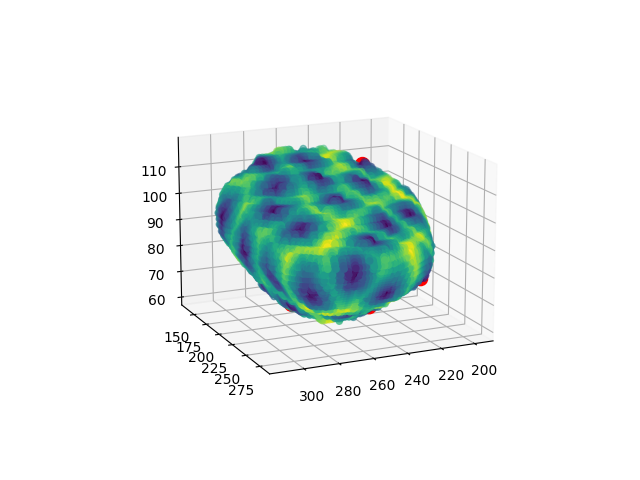

In [9]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color_faces = np.hstack([
    ar_dist[faces1].mean(1),
    ar_dist[faces1].mean(1),
    ar_dist[faces1].mean(1)
]).T

# m = plt.cm.ScalarMappable(norm=color_faces, cmap='jet')
# m.set_array([])
# fcolors = m.to_rgba(color_dimension)

# ax.plot_trisurf(*verts1.T, triangles=faces1, color=[0, 0, 1], alpha=.7)
ax.scatter(*verts1.T, c=ar_dist)
ax.scatter(*verts1[all_points].T, c='r', s=100, alpha=1)


# I) Registration

In [35]:
# %%

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-11.nii.gz")
seg1n = nib.load(path_segm)
seg1 = np.round(seg1n.get_fdata()) == 2

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-10.nii.gz")
seg2n = nib.load(path_segm)
seg2 = np.round(seg2n.get_fdata()) == 2


In [36]:
%%time
reload_modules()
reg1 = (u.get_most_important_regions(seg1) > 0).astype(int)
reg2 = (u.get_most_important_regions(seg2) > 0).astype(int)



CPU times: user 16.9 s, sys: 674 ms, total: 17.6 s
Wall time: 17.6 s


In [37]:
%%time
verts1, faces1, normals1, values1 = meas.marching_cubes(reg1, step_size=4)
verts2, faces2, normals2, values2 = meas.marching_cubes(reg2, step_size=4)


CPU times: user 405 ms, sys: 108 ms, total: 513 ms
Wall time: 512 ms


<IPython.core.display.Javascript object>


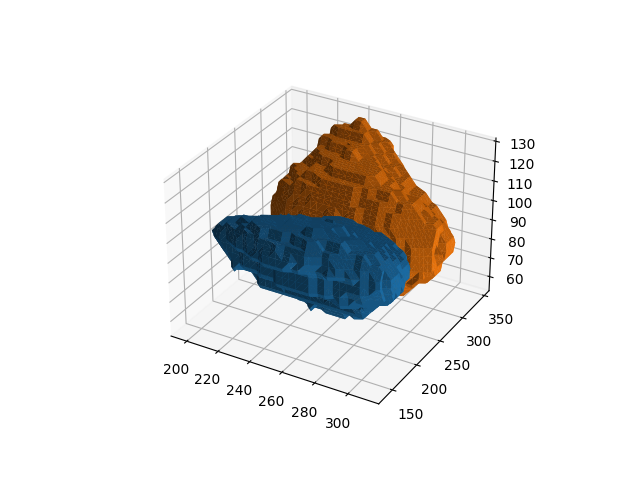

In [38]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(*verts1.T, triangles=faces1)
ax.plot_trisurf(*verts2.T, triangles=faces2)


<IPython.core.display.Javascript object>


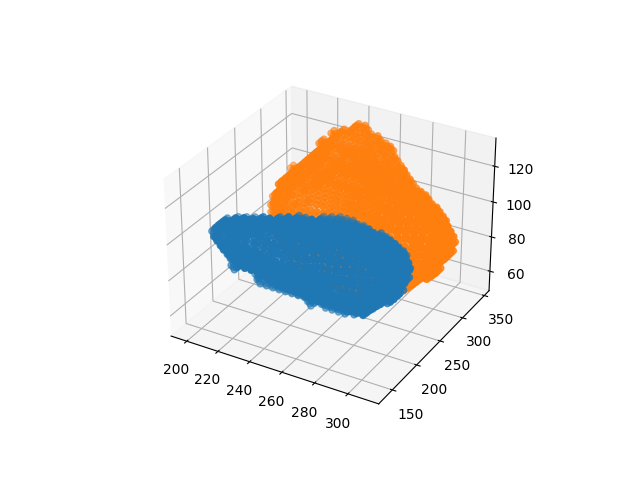

In [27]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*verts1.T,)
ax.scatter(*verts2.T,)


In [39]:
mean1, std1 = verts1.mean(0), verts1.std(0)
mean2, std2 = verts2.mean(0), verts2.std(0)

nverts1 = (verts1 - mean1)/std1
nverts2 = (verts2 - mean2)/std2

<IPython.core.display.Javascript object>


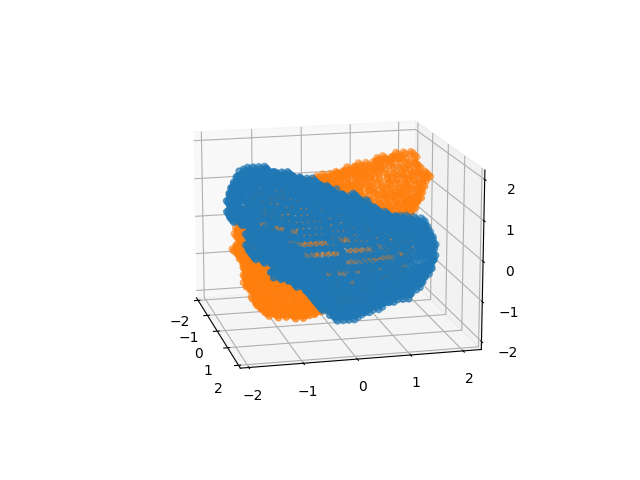

In [40]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*nverts1.T,)
ax.scatter(*nverts2.T,)


In [41]:
%%time
reload_modules()
T, errs, n_iters = icp.icp(nverts1, nverts2, allow_reflection=False, max_iterations=1000, tolerance=1e-5)
print(T, np.max(errs), n_iters)

[[ 0.99950916  0.02791258  0.01422405  0.01002564]
 [-0.02296148  0.96159541 -0.27350874 -0.13305637]
 [-0.02131212  0.27304788  0.96176434 -0.0616374 ]
 [ 0.          0.          0.          1.        ]] 0.925477981364535 60
CPU times: user 348 ms, sys: 7.21 ms, total: 355 ms
Wall time: 353 ms


<IPython.core.display.Javascript object>


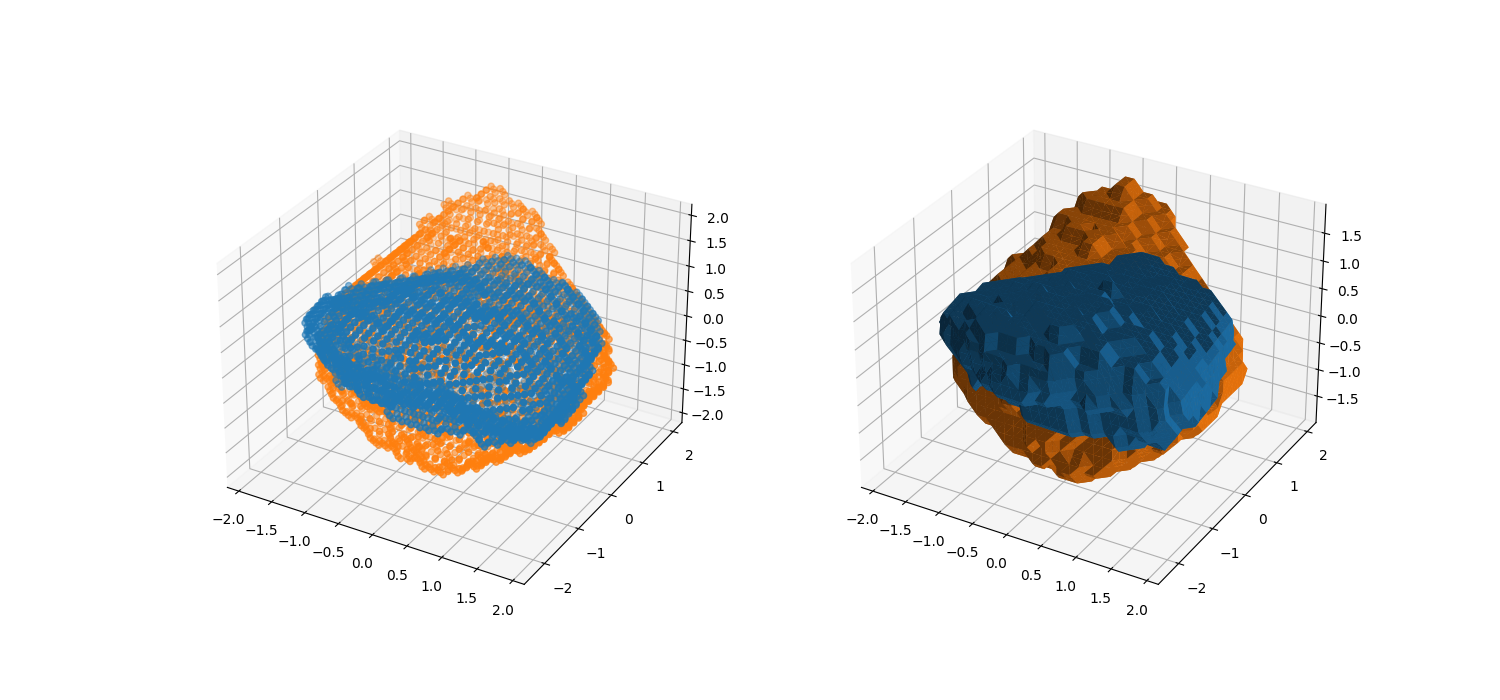

In [42]:
# %%
def transform_cloud(T, mat):
    return ((T @ np.hstack((mat, np.ones((mat.shape[0], 1)))).T).T)[:, :-1]

Tverts1 = transform_cloud(T, nverts1)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*Tverts1.T,)
ax1.scatter(*nverts2.T,)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(*Tverts1.T, triangles=faces1)
ax2.plot_trisurf(*nverts2.T, triangles=faces2)

In [111]:

def get_norm_transform(mean, std, invert=False):
    Tn = np.eye(4)

    if invert:
        Tn[:-1, -1] += mean
        Tn[:3, :3] *= std
    else:
        Tn[:-1, -1] -= mean/std
        Tn[:3, :3] /= std
    return Tn

Tn1 = get_norm_transform(mean1, std1, invert=False)
Tn2 = get_norm_transform(mean2, std2, invert=True)
T2 = Tn2 @ T @ Tn1

<IPython.core.display.Javascript object>


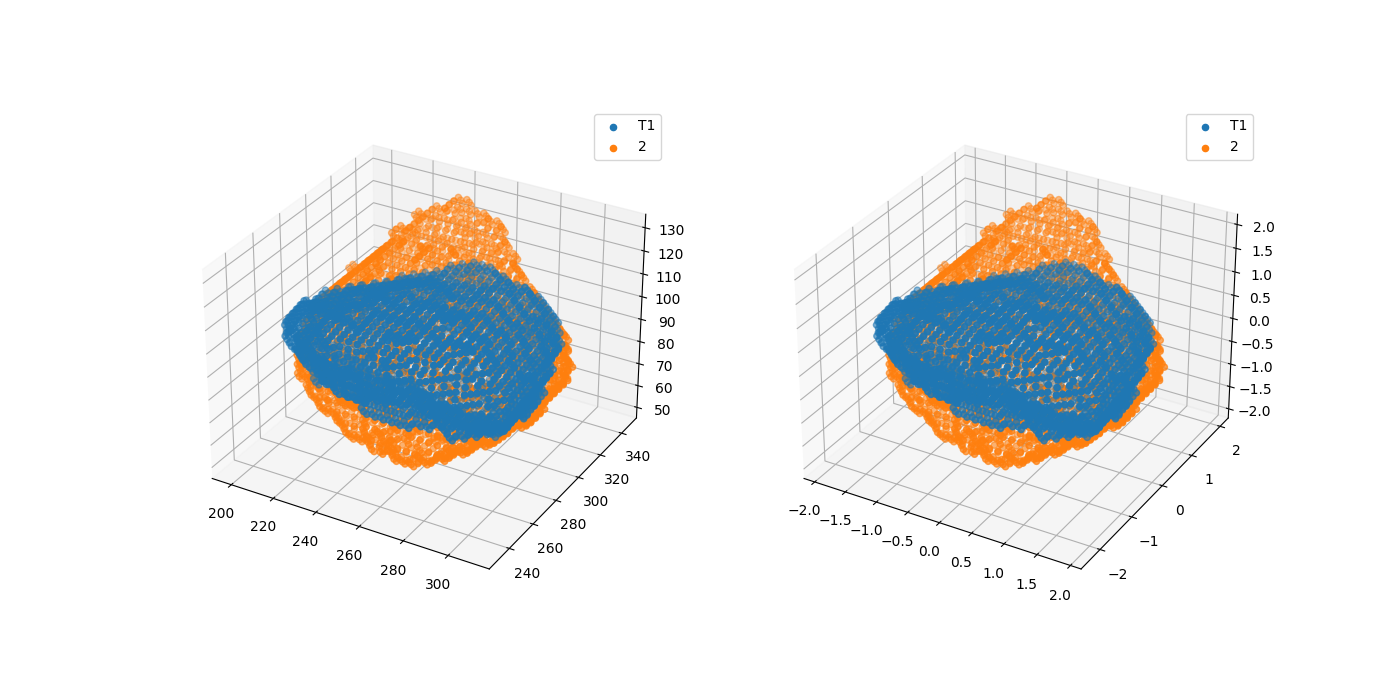

In [112]:


# T2verts1 = transform_cloud(T2, verts1 - mean1)
T2verts1 = transform_cloud(T2, verts1)

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*T2verts1.T, label="T1")
ax1.scatter(*verts2.T, label="2")
ax1.legend()

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(*Tverts1.T, label="T1")
ax1.scatter(*nverts2.T, label="2")
ax1.legend()

In [158]:
def sort_by_regex(lis, regex=r'labels-(\d+)'):
    return sorted(lis, key=lambda x: int(re.findall(regex, x)[0]))

labels_dir = "/hdd/datasets/CT-ORG/raw/labels_and_README/"
all_labels = sort_by_regex([os.path.join(labels_dir, filename) for filename in 
    os.listdir(labels_dir) if re.findall(r"labels-", filename)])

ref_path = all_labels[5]


In [206]:
dest_dir = "/hdd/datasets/CT-ORG/meshes/labels/"
step_size=4
only_new = True

for idx in tqdm(range(len(all_labels))):
    label_path = all_labels[idx]
    label_name = pathlib.Path(label_path).stem
    dest = os.path.join(dest_dir, label_name, f"step_size_{step_size}")
    if only_new and os.path.exists(dest):
        continue
    
    seg = np.round(nib.load(label_path).get_fdata()) == 2
    if seg.sum() == 0:
        continue
    reg = (u.get_most_important_regions(seg) > 0).astype(int)
    verts, faces, normals, values = meas.marching_cubes(reg, step_size=step_size)

    pathlib.Path(dest).mkdir(exist_ok=True, parents=True)
    np.save(os.path.join(dest, "vertexes.npy"), verts)
    np.save(os.path.join(dest, "faces.npy"), faces)
    np.save(os.path.join(dest, "normals.npy"), normals)
    np.save(os.path.join(dest, "values.npy"), values)

    

100%|██████████| 140/140 [20:51<00:00,  8.94s/it]


/hdd/datasets/CT-ORG/meshes/labels/labels-12.nii/step_size_1


<IPython.core.display.Javascript object>


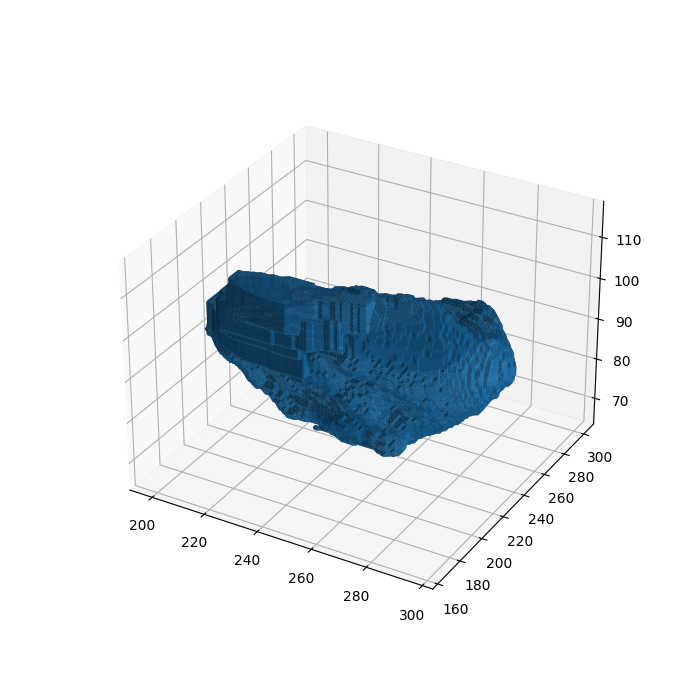

In [173]:
mesh_dir = "/hdd/datasets/CT-ORG/meshes/labels/"
dest = os.path.join(mesh_dir, random.choice(os.listdir(mesh_dir)), 'step_size_1')
print(dest)

verts = np.load(os.path.join(dest, "vertexes.npy"))
faces = np.load(os.path.join(dest, "faces.npy"))

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(*verts.T, triangles=faces)

# ax1 = fig.add_subplot(122, projection='3d')
# ax1.scatter(*verts.T)

/hdd/datasets/CT-ORG/meshes/labels/labels-2.nii/step_size_4


100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


<IPython.core.display.Javascript object>


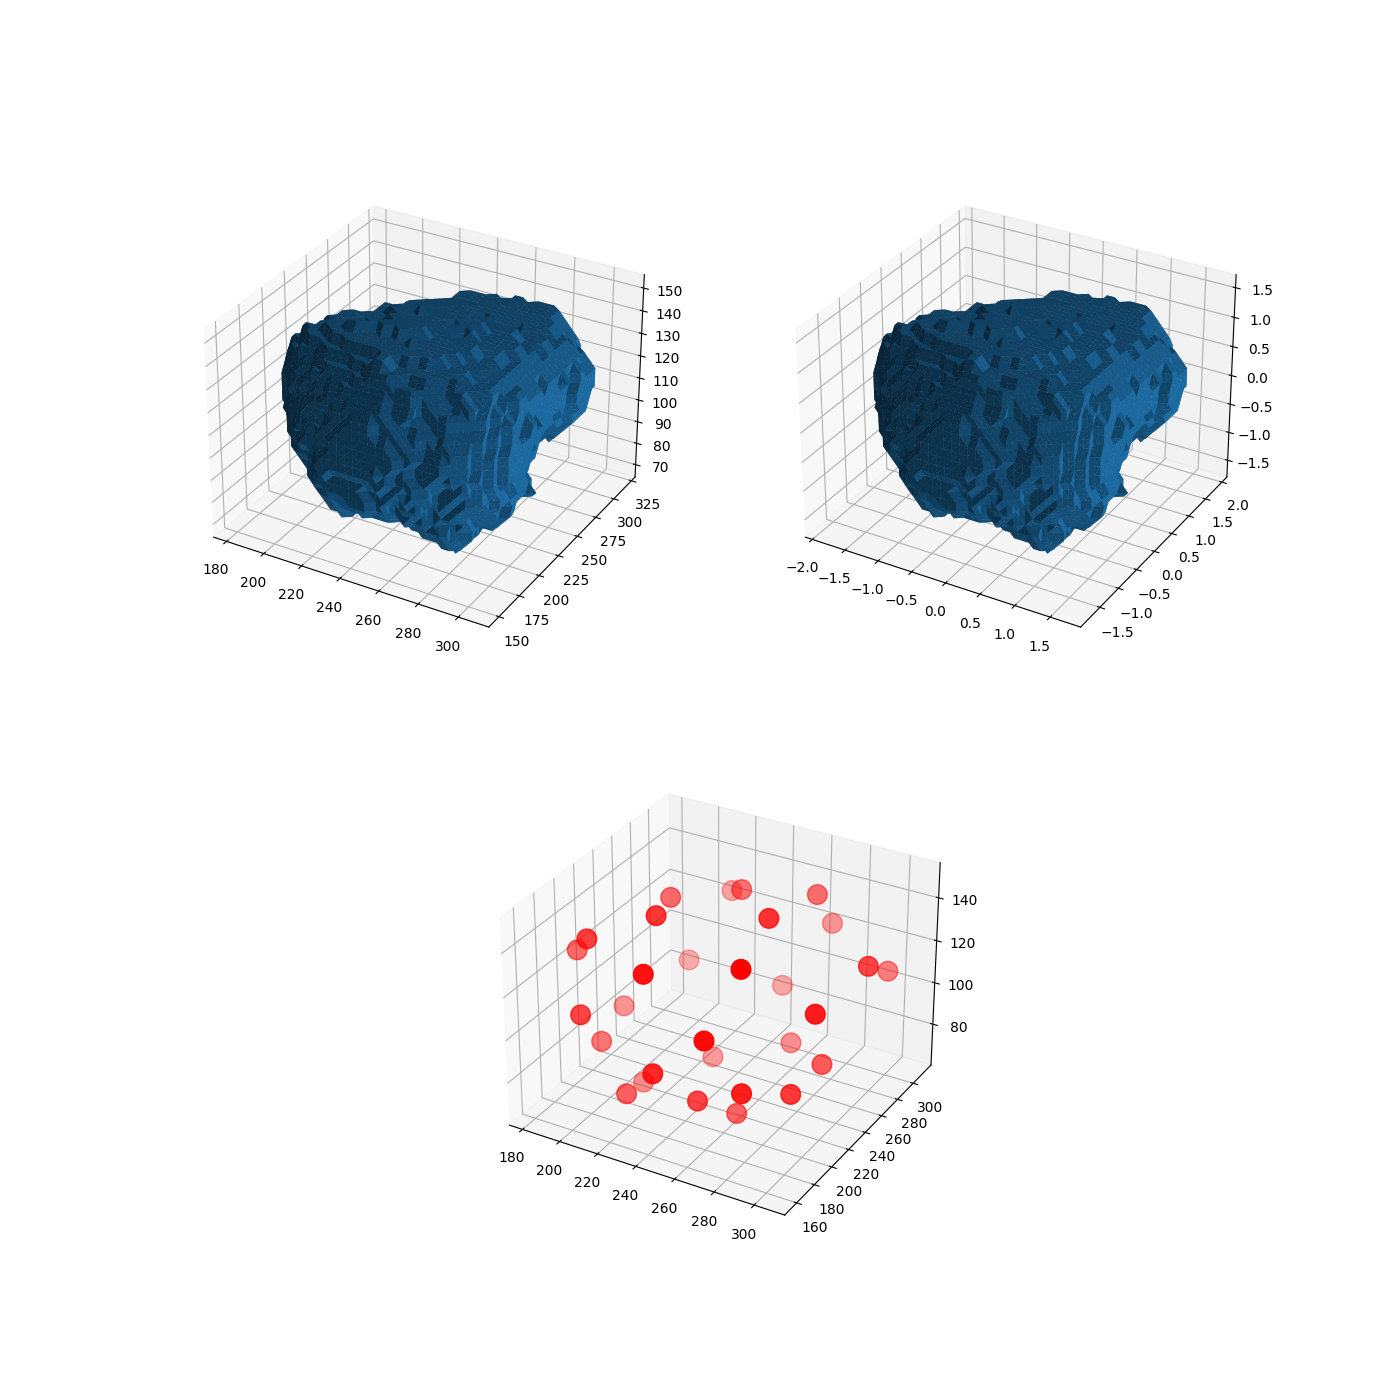

In [243]:
mesh_dir = "/hdd/datasets/CT-ORG/meshes/labels/"
step_size = 4

all_meshes = sort_by_regex([
    os.path.join(mesh_dir, filename, f"step_size_{step_size}") for filename in os.listdir(mesh_dir)
])
ref_mesh = all_meshes[2]
print(ref_mesh)
ref_verts = np.load(os.path.join(ref_mesh, "vertexes.npy"))
ref_faces = np.load(os.path.join(ref_mesh, "faces.npy"))

sampling = smesh.dijkstra_sampling(ref_verts, ref_faces, 30)


Tnref = get_norm_transform(ref_verts.mean(0), ref_verts.std(0))
nref_verts = transform_cloud(Tnref, ref_verts)




<IPython.core.display.Javascript object>


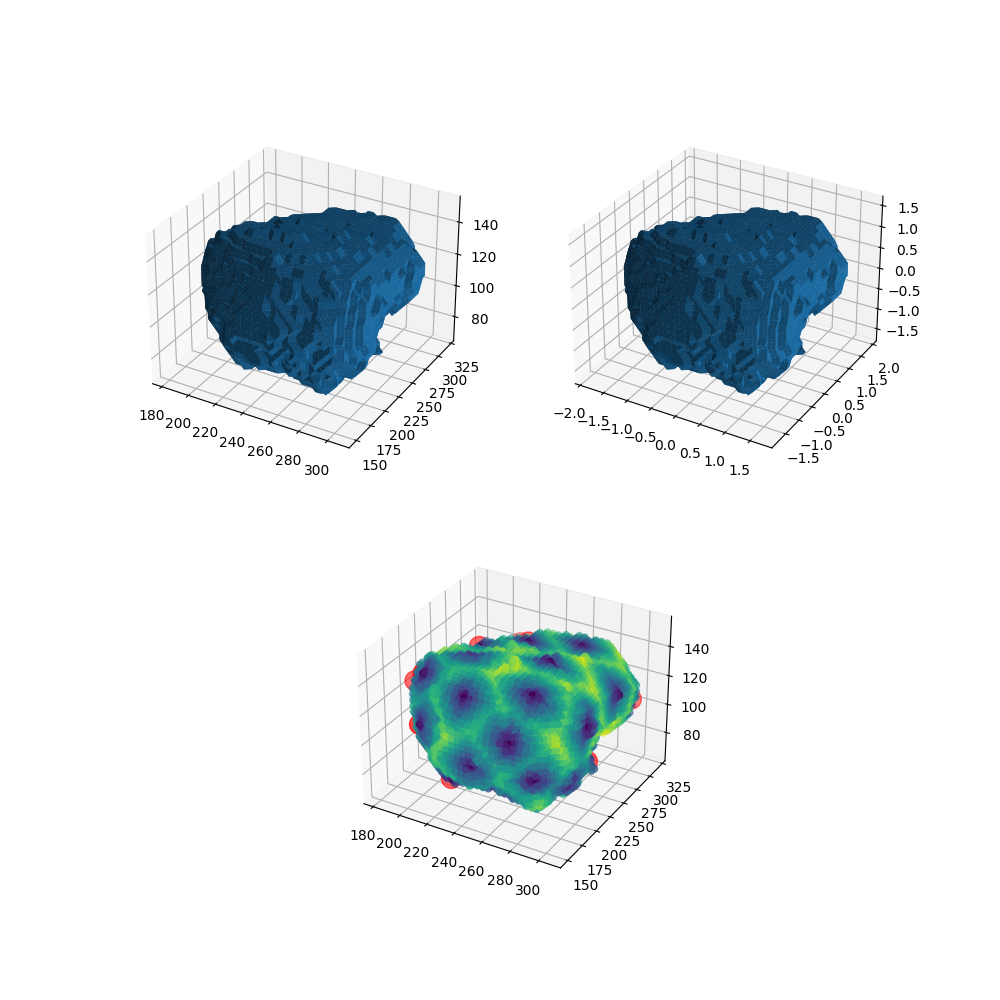

In [316]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_trisurf(*ref_verts.T, triangles=ref_faces)

ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_trisurf(*nref_verts.T, triangles=ref_faces)

ax1 = fig.add_subplot(212, projection='3d')
ax1.scatter(*sampling[0].T, c='r', s=200)
ax1.scatter(*ref_verts.T, c=sampling[1])

In [210]:
# Not using shape class

n_labels = 30
all_dfs = []

Tnref = get_norm_transform(ref_verts.mean(0), ref_verts.std(0))
nref_verts = transform_cloud(Tnref, ref_verts)

iterator = sort_by_regex(list(set(all_meshes).difference([ref_mesh])))[:n_labels]
for idx in tqdm(range(len(iterator))):
    mesh_path = iterator[idx]
    verts = np.load(os.path.join(mesh_path, 'vertexes.npy'))
    vmean, vstd = verts.mean(0), verts.std(0)
    nverts = (verts - vmean) / vstd
    Tinv_verts = get_norm_transform(vmean, vstd, invert=True)
    T, errs, n_iters = icp.icp(
        nref_verts, nverts, allow_reflection=False, max_iterations=1000, tolerance=1e-5)
    all_dfs.append(pd.DataFrame({
        'mesh_path': [mesh_path],
        'label': [re.findall('labels-(\d+)', mesh_path)[0]],
        'transform': [Tinv_verts @ T @ Tnref],
        'errors': [errs],
        'n_iters': [n_iters],
        'step_size': [re.findall('step_size_(\d+)', mesh_path)[0]]
    }))

all_dfs = pd.concat(all_dfs)

100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


0.21386688425256678
/hdd/datasets/CT-ORG/meshes/labels/labels-16.nii/step_size_4


<IPython.core.display.Javascript object>


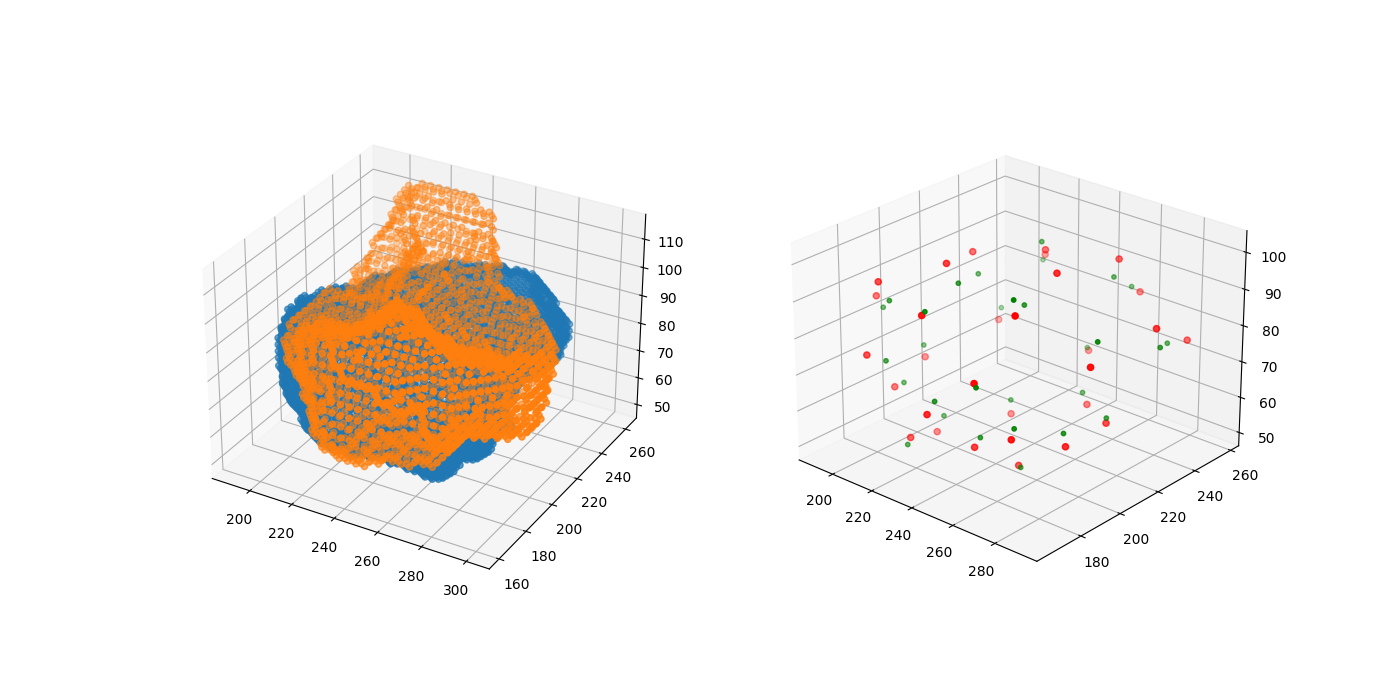

In [266]:
reload_modules()
idx = random.choice(range(len(all_dfs)))
cur_row = all_dfs.iloc[idx]
verts = np.load(os.path.join(cur_row['mesh_path'], 'vertexes.npy'))
faces = np.load(os.path.join(cur_row['mesh_path'], 'faces.npy'))
T = cur_row['transform']


print(cur_row['errors'].mean())
print(cur_row['mesh_path'])

Tref_verts = transform_cloud(T, ref_verts)
Tsampling = transform_cloud(T, sampling[0])
distances, neigh_sampling = icp.nearest_neighbor(Tsampling, verts)

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*Tref_verts.T, label="Tref")
ax1.scatter(*verts.T, label="shape")
# ax1.plot_trisurf(*Tref_verts.T, triangles=ref_faces, label="Tref")
# ax1.plot_trisurf(*verts.T, triangles=faces, label="shape")
# ax1.legend()

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(*Tsampling.T, label="ref", c='r', s=20)
ax1.scatter(*verts[neigh_sampling].T, label="shape", c='g', s=10)


In [321]:
# Using shape class

reload_modules()
mesh_dir = "/hdd/datasets/CT-ORG/meshes/labels/"
step_size = 4

all_meshes = sort_by_regex([
    os.path.join(mesh_dir, filename, f"step_size_{step_size}") for filename in os.listdir(mesh_dir)
])
ref_mesh = all_meshes[2]
print(ref_mesh)
ref_verts = np.load(os.path.join(ref_mesh, "vertexes.npy"))
ref_faces = np.load(os.path.join(ref_mesh, "faces.npy"))

ref_shape = sh.Shape(label=ref_mesh, vertexes=ref_verts, faces=ref_faces)
ref_shape.perform_sampling(20)


n_shapes = 10
all_shapes = []
all_errs = []
all_n_iters = []

iterator = sort_by_regex(list(set(all_meshes).difference([ref_mesh])))[:n_shapes]
for idx in tqdm(range(len(iterator))):
    mesh_path = iterator[idx]
    verts = np.load(os.path.join(mesh_path, 'vertexes.npy'))
    cur_shape = sh.Shape(label=mesh_path, vertexes=verts)
    cur_shape.set_reference(ref_shape)
    _, errs, n_iters = cur_shape.register_icp_to_reference()
    cur_shape.align_samples()
    
    all_shapes.append(cur_shape)
    all_errs.append(errs)
    all_n_iters.append(n_iters)

  0%|          | 0/20 [00:00<?, ?it/s]

/hdd/datasets/CT-ORG/meshes/labels/labels-2.nii/step_size_4


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


/hdd/datasets/CT-ORG/meshes/labels/labels-7.nii/step_size_4
[[ 1.05159985e+00 -4.20369523e-02  7.53484229e-03  5.02909519e+00]
 [ 5.19954973e-02  7.42712191e-01 -1.99681932e-01  1.23338855e+02]
 [ 2.10420634e-03  9.17244736e-02  1.07805476e+00 -1.47390593e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<IPython.core.display.Javascript object>


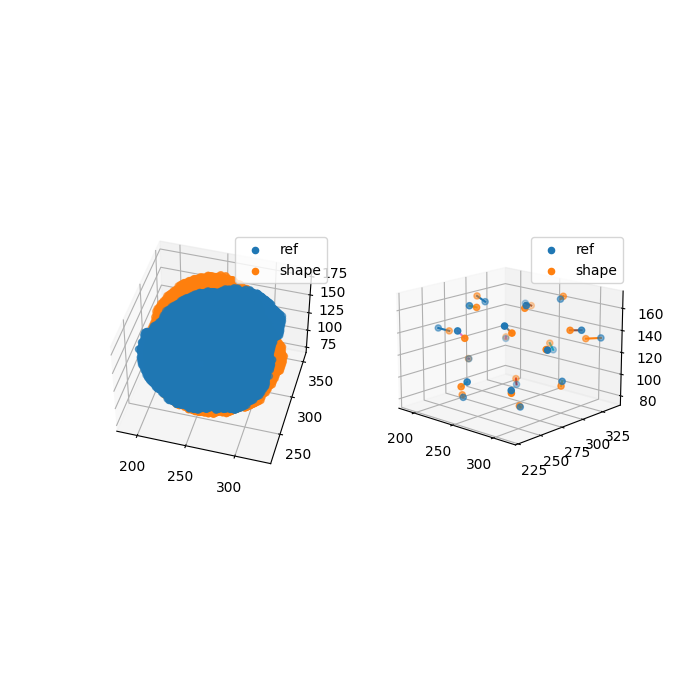

<Axes3DSubplot:>

In [322]:
cur_shape = random.choice(all_shapes)
print(cur_shape.label)
print(cur_shape.Tref)

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(121, projection='3d')
cur_shape.plot_compare_point_cloud(ax1)

ax1 = fig.add_subplot(122, projection='3d')
cur_shape.plot_compare_samples(ax1)

In [ ]:
# %%
u.save_as_nii(
    "segmentations/CT_ORG/labels-4-opened.nii.gz",
    reg3,
    seg3n.affine,
    dtype=np.uint8
)


In [19]:
def get_ellipse_fn(center, matrix, radius):
    def fn(*x):
        W, L, H = x[0].shape
        Z = np.zeros_like(x[0])
        for i in range(W):
            for j in range(L):
                for k in range(H):
                    coord = np.array([x[0][i, j, k], x[1][i, j, k], x[2][i, j, k]]) - center
                    coord = coord[:, np.newaxis]
                    Z[i, j, k] = np.sqrt( coord.T @ matrix @ coord) - radius
        return Z
    return fn

def get_ellipsoid_points(center, matrix, radius, shape=(40, 40, 40), eps=1e-1):

    XX, YY, ZZ = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    fn_ellipse = get_ellipse_fn(center, matrix, radius)
    lvset = fn_ellipse(XX, YY, ZZ)
    mask = np.zeros_like(lvset)
    mask[(-eps < lvset) & (lvset < eps)] = 1
    Xs, Ys, Zs = np.where(mask)
    return np.concatenate((Xs[:, np.newaxis], Ys[:, np.newaxis], Zs[:, np.newaxis]), axis=1)


In [161]:
%%time
shape = (70, 70, 70)
eps=1e-3

A1= np.array([
    [6, 2, 1],
    [2, 2, 0],
    [1, 0, 1]
])
center1 = np.array([15, 10, 10])
radius1 = 5

ell1 = get_ellipsoid_points(center1, A1, radius1, shape=shape, eps=eps)

A2 = np.array([
    [6, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
])
center2 = np.array([10, 10, 10])
radius2 = 5

ell2 = get_ellipsoid_points(center2, A2, radius2, shape=shape, eps=eps)

CPU times: user 2.93 s, sys: 10.1 ms, total: 2.94 s
Wall time: 2.94 s


<IPython.core.display.Javascript object>


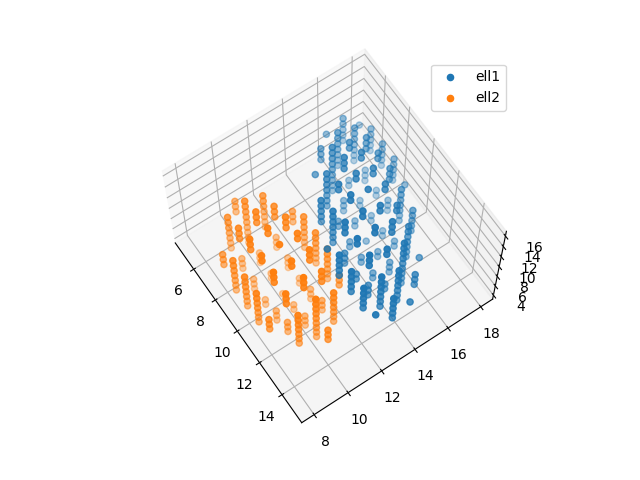

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*ell1.T, label='ell1')
ax.scatter(*ell2.T, label='ell2')
ax.legend()

In [91]:
%%timeit
reload_modules()
T, errs, iters = icp.icp(ell1, ell2, n_points=20)


11.7 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [151]:
all_errs = []
all_errs2 = []
all_n_points = range(1, len(ell1))
T_opt = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, -5],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

for n_pt in tqdm(all_n_points):
    T, errs ,iters = icp.icp(ell1, ell2, n_points=n_pt, max_iterations=1000)
    all_errs.append(np.abs(errs).max())
    all_errs2.append(np.max(T - T_opt))

100%|██████████| 183/183 [00:12<00:00, 15.09it/s]


<IPython.core.display.Javascript object>


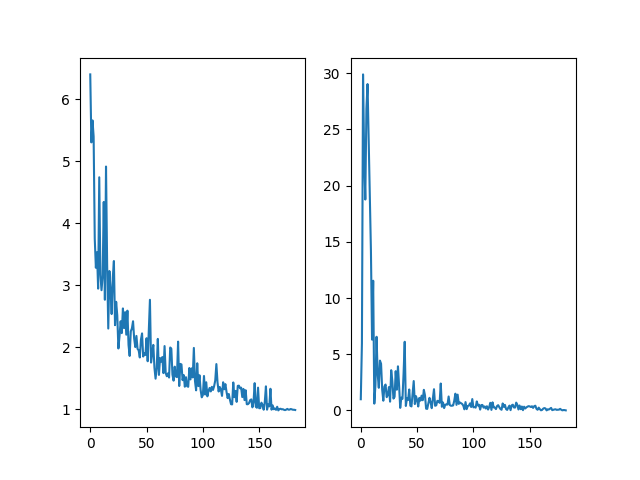

In [152]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(all_errs)
axs[1].plot(all_errs2)

In [121]:
print(T)
print(np.abs(errs).mean())
print(iters)

[[ 1.00000000e+00 -9.90796275e-07 -1.41774147e-06  2.90207983e-05]
 [ 9.89326211e-07  9.99999463e-01 -1.03653054e-03 -4.98964221e+00]
 [ 1.41876770e-06  1.03653054e-03  9.99999463e-01 -2.10099371e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0.011818425868727712
7


In [163]:
reload_modules()
T, errs, iters = icp.icp(ell1, ell2)
print(T)
print(np.abs(errs).max())
print(iters)

[[ 0.89959054 -0.31147948 -0.30613296  8.77730865]
 [ 0.37209864  0.91361427  0.16386447 -9.0799491 ]
 [ 0.22864702 -0.26132259  0.93777985  2.30011588]
 [ 0.          0.          0.          1.        ]]
1.937060309529838
15


<IPython.core.display.Javascript object>


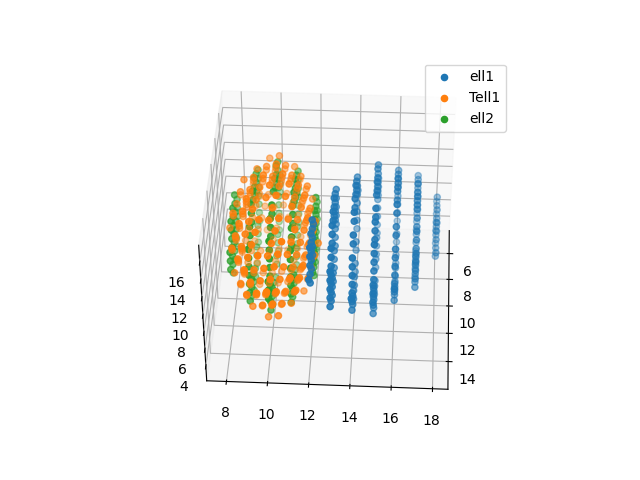

In [164]:
Tell2 = ((T @ np.hstack((ell2, np.ones((ell2.shape[0], 1)))).T).T)[:, :-1]
Tell1 = ((T @ np.hstack((ell1, np.ones((ell1.shape[0], 1)))).T).T)[:, :-1]

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(*ell1.T, label='ell1')
ax1.scatter(*Tell1.T, label='Tell1')
ax1.scatter(*ell2.T, label='ell2')
ax1.legend()

In [35]:
T.shape

(4, 4)

# II) Alignment

# III) Statistics

# IV) Inference